In [1]:
import numpy as np, pandas as pd, torch, os, glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
#pickle loading
# merge experiment
model_name_s = "ST-DBMCv1" #,ST-DBMCv1, ST-DBMCv2, BERT
PeriHD_BERT_data_train_pkl = glob.glob(f"./dataset/PeriHD_pickle_save_05-17/{model_name_s}_sample2693_only-merge-sequence_contextsplit/train/*_fixed_re-marked_merge.pkl")
PeriHD_BERT_data_valid_pkl = glob.glob(f"./dataset/PeriHD_pickle_save_05-17/{model_name_s}_sample2693_only-merge-sequence_contextsplit/valid/*_fixed_re-marked_merge.pkl")
IntraHD_BERT_data_train_pkl = glob.glob(f"./dataset/IntraHD_pickle_save_05-17/{model_name_s}_sample1124_sequence_fullcontext/train/*_fixed_re-marked_merge.pkl")
IntraHD_BERT_data_valid_pkl = glob.glob(f"./dataset/IntraHD_pickle_save_05-17/{model_name_s}_sample1124_sequence_fullcontext/valid/*_fixed_re-marked_merge.pkl")

In [3]:
def pk2pf(pkl_list):
    data_train = []
    for pk in pkl_list:
        with open(pk, 'rb') as f:
            pk_dict = pickle.load(f)
        data_train.append(pk_dict)
    data_train = pd.DataFrame(data_train)
    
    return data_train
PeriHD_BERT_data_train = pk2pf(PeriHD_BERT_data_train_pkl)
PeriHD_BERT_data_valid = pk2pf(PeriHD_BERT_data_valid_pkl)
IntraHD_BERT_data_train = pk2pf(IntraHD_BERT_data_train_pkl)
IntraHD_BERT_data_valid = pk2pf(IntraHD_BERT_data_valid_pkl)
print(len(PeriHD_BERT_data_train), len(IntraHD_BERT_data_train))
PeriHD_BERT_data_train['datatype']='PeriHD'
PeriHD_BERT_data_valid['datatype']='PeriHD'
IntraHD_BERT_data_train['datatype']='IntraHD'
IntraHD_BERT_data_valid['datatype']='IntraHD'
BERT_data_train = pd.concat([PeriHD_BERT_data_train, IntraHD_BERT_data_train])
BERT_data_valid = pd.concat([PeriHD_BERT_data_valid, IntraHD_BERT_data_valid])

12047 1011


In [4]:
print(len(BERT_data_train.label.values)-sum(BERT_data_train.label.values), sum(BERT_data_train.label.values))
print(len(BERT_data_valid.label.values)-sum(BERT_data_valid.label.values), sum(BERT_data_valid.label.values))

11658 1400
1520 155


In [5]:
# ### BERT model embedding
BERT_training_embeddings = np.array(BERT_data_train.embed.tolist())
BERT_validation_embeddings = np.array(BERT_data_valid.embed.tolist())
print("Internal train", BERT_training_embeddings.shape)
print("Internal test" ,BERT_validation_embeddings.shape)

Internal train (13058, 512)
Internal test (1675, 512)


In [6]:
import keras
def create_model(input_shape = (512,)):
  model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape = input_shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  # model.compile(loss=FocalTverskyLoss, 
  #             optimizer='adam',
  #             metrics=['acc'])
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
  return model

2023-05-23 10:25:39.584987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 10:25:39.750433: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 10:25:40.300995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-23 10:25:40.301071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

2023-05-23 10:26:00.821328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-23 10:26:00.836728: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2381672a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-23 10:26:00.836758: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-23 10:26:00.852449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-23 10:26:01.002851: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-23 10:26:01.075580: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most on

53/53 [==============================] - 0s 2ms/step


Text(0.5, 1.0, '[Internal][ST-DBMCv1]PeriHD + IntraHD Validation ROC-Curve')

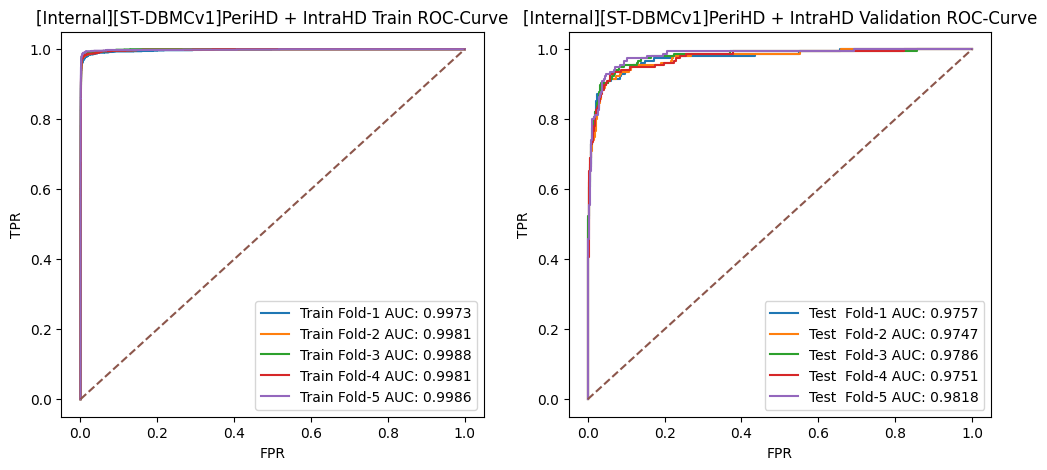

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
def get_weight_path(fold, train_type):
    return "./model_weight/PeriHD_and_IntraHD/weights_{}_KFold={}[{}neg+pos-05-17].h5".format(model_name_s,fold,train_type)
# return "./model_weight/PeriHD_and_IntraHD/weights_periHD_KFold={}[{}-only-merge-sequnece-resplit].h5".format(fold,train_type)
    # return "./model_weight/PeriHD/weights_periHD_KFold={}[{}-only-merge-sequnece-resplit].h5".format(fold,train_type)
    
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
history_stack = []
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19,5))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
CM_train = []
CM_test = []
eval = False
train_type = model_name_s
fold_no = 1

in_shape = 512
training_embedding_ = BERT_training_embeddings
validation_embedding = BERT_validation_embeddings
data_train = BERT_data_train
data_valid = BERT_data_valid

train_binary_pred_and_score = []
test_binary_pred_and_score = [ ]
for train, test in kfold.split(training_embedding_, data_train['label'].values.tolist()):
    weight_name = get_weight_path(fold_no, train_type)
    cls_model = create_model(input_shape=(in_shape,))
    if eval==False:
        callbacks = [
            EarlyStopping(     #EarlyStopping is BERTd to stop at the epoch where val_accuracy does not improve significantly
                monitor='val_loss',
                min_delta=1e-4,
                patience=10,
                verbose=0
            ),
            ModelCheckpoint(
                filepath=weight_name,
                monitor='val_loss', 
                mode='min', 
                save_best_only=True,
                save_weights_only=True,
                verbose=0
            )
        ]
        history = cls_model.fit(training_embedding_[train], 
                data_train['label'].values[train], 
                batch_size=64, 
                validation_data=(training_embedding_[test], data_train['label'].values[test]), 
                epochs=300, 
                callbacks=callbacks,verbose=0)
        history_stack.append(history)

    elif eval==True:
        cls_model.load_weights(weight_name)
    train_pred = cls_model.predict(training_embedding_)
    test_pred = cls_model.predict(validation_embedding)
    # binary_pred = np.argmax(pred, axis=1)
    train_binary_pred = (train_pred>0.5).astype(np.int8)
    test_binary_pred = (test_pred>0.5).astype(np.int8)
    train_binary_pred_and_score.append([train_pred, train_binary_pred])
    test_binary_pred_and_score.append([test_pred, test_binary_pred])
    
    tn, fp, fn, tp = confusion_matrix(data_train['label'].values, train_binary_pred).ravel()
    # CM_train.append([tn, fp, fn, tp])
    CM_train.append([data_train['label'].values, train_binary_pred])
    tn, fp, fn, tp = confusion_matrix(data_valid['label'].values, test_binary_pred).ravel()
    # CM_test.append([tn, fp, fn, tp])
    CM_test.append([data_valid['label'].values, test_binary_pred])
    
    fpr, tpr, thresholds = roc_curve(data_train['label'].values, train_pred, pos_label=1)
    auc = roc_auc_score(data_train['label'].values, train_pred)
    axs[0].plot(fpr, tpr, label = "Train Fold-{} AUC: {}".format(fold_no, round(auc, 4)))

    fpr, tpr, thresholds = roc_curve(data_valid['label'].values, test_pred, pos_label=1)
    auc = roc_auc_score(data_valid['label'].values, test_pred)
    axs[1].plot(fpr, tpr, label = "Test  Fold-{} AUC: {}".format(fold_no, round(auc, 4)))
    fold_no=fold_no+1

axs[0].plot([0,1],[0,1], linestyle='--')
axs[1].plot([0,1],[0,1], linestyle='--')

axs[0].legend()
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].set_title(f"[Internal][{train_type}]PeriHD + IntraHD Train ROC-Curve")
axs[1].legend()
axs[1].set_xlabel("FPR")
axs[1].set_ylabel("TPR")
axs[1].set_title(f"[Internal][{train_type}]PeriHD + IntraHD Validation ROC-Curve")

In [8]:
# history_stack[0].history

In [9]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
# 已標記資料效能評估
def metric_calc(array_):
    y_test, y_pred = array_
    report = classification_report(y_test, y_pred, output_dict=True)
    # macro_f1 = report['macro avg']['f1-score']
    # weighted_f1 = report['weighted avg']['f1-score']
    # macro_precision = report['macro avg']['precision']
    # weighted_precision = report['weighted avg']['precision']
    # macro_recall = report['macro avg']['recall']
    # weighted_recall = report['weighted avg']['recall']
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    sens = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn/(tn+fp)
    return acc, prec, sens, spec, f1

def get_metric(arr):
    mean_arr = np.mean(np.array(arr), axis=0)
    std_arr = np.std(np.array(arr), axis=0)
    return mean_arr, std_arr

In [10]:

# CM_train = np.array(CM_train)
# CM_test = np.array(CM_test)
T_stack, t_stack = [],[]
for T_ in CM_train:
    T_stack.append(metric_calc(T_))
    
for t_ in CM_test:
    t_stack.append(metric_calc(t_))
#內部資料 - Train & Test
mark_train_mean, mark_train_std = get_metric(T_stack)
mark_test_mean, mark_test_std = get_metric(t_stack)
mark_train = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]'], columns=[f'{train_type} Metric Train'])
for T_, f in zip(T_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_train[f] = np.round(T_,4)
mark_train['Mean'] = np.round(mark_train_mean,4)
mark_train['Std'] = np.round(mark_train_std,4)

mark_test = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]'], columns=[f'{train_type} Metric Validation'])
for t_, f in zip(t_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_test[f] = np.round(t_,4)
mark_test['Mean'] = np.round(mark_test_mean,4)
mark_test['Std'] = np.round(mark_test_std,4)

In [11]:
temp = {'Train&Valid斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for fold_result in train_binary_pred_and_score:
    train_pred_singel = fold_result[0].flatten()
    train_binary_pred_singel = np.round(fold_result[1].flatten(),3).astype(np.float16)
    for i in zip(BERT_data_train['text'].tolist(), BERT_data_train['label'].tolist(),train_binary_pred_singel, train_pred_singel):
        if i[1]!=i[2]:
            temp['Train&Valid斷句'].append(i[0])
            temp['真實答案'].append(i[1])
            temp['預測答案'].append(i[2])
            temp['預測分數'].append(i[3])

for fold_result in test_binary_pred_and_score:
    test_pred_singel = fold_result[0].flatten()
    test_binary_pred_singel = np.round(fold_result[1].flatten(),3).astype(np.float16)
    for i in zip(BERT_data_train['text'].tolist(), BERT_data_train['label'].tolist(),test_binary_pred_singel, test_pred_singel):
        if i[1]!=i[2]:
            temp['Train&Valid斷句'].append(i[0])
            temp['真實答案'].append(i[1])
            temp['預測答案'].append(i[2])
            temp['預測分數'].append(i[3])

failed_pf = pd.DataFrame(temp, columns=['Train&Valid斷句','真實答案','預測答案','預測分數'])

In [12]:
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 20)
# failed_pf = failed_pf.drop_duplicates(subset='Train&Valid斷句')
# failed_pf.to_csv("./total_fold_faild_predict.csv", index=False, encoding='utf-8-sig')


In [13]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 20)
temp = {'斷句': [],'真實答案': [],'預測答案': [],'預測分數': [], '資料型態': []}
for i in zip(BERT_data_train['text'].tolist(), BERT_data_train['label'].tolist(),train_binary_pred.flatten(), train_pred.flatten(), BERT_data_train.datatype):
    if i[1]!=i[2]:
        temp['斷句'].append(i[0])
        temp['真實答案'].append(i[1])
        temp['預測答案'].append(i[2])
        temp['預測分數'].append(np.round(i[3],3))
        temp['資料型態'].append(i[4])
train_failed_pf = pd.DataFrame(temp, columns=['斷句','真實答案','預測答案','預測分數', '資料型態'])

In [14]:
# train_failed_pf

In [15]:
temp = {'斷句': [],'真實答案': [],'預測答案': [],'預測分數': [], '資料型態': []}
for i in zip(BERT_data_valid['text'].tolist(), BERT_data_valid['label'].tolist(),test_binary_pred.flatten(), test_pred.flatten(), BERT_data_valid.datatype):
    if i[1]!=i[2]:
        temp['斷句'].append(i[0])
        temp['真實答案'].append(i[1])
        temp['預測答案'].append(i[2])
        temp['預測分數'].append(np.round(i[3],3))
        temp['資料型態'].append(i[4])
test_failed_pf = pd.DataFrame(temp, columns=['斷句','真實答案','預測答案','預測分數', '資料型態'])

In [16]:
# test_failed_pf

In [17]:
pd.concat([train_failed_pf, test_failed_pf]).to_csv(f"./failed_predict_peri+intra_sentence_train&test[{model_name_s}][merge-neg+pos].csv", encoding='utf-8-sig', index=False)

In [18]:
mark_train

,ST-DBMCv1 Metric Train,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9923,0.9932,0.9940,0.9936,0.9945,0.9935,0.0007
1,Precision [macro],0.9847,0.9847,0.9812,0.9862,0.9898,0.9853,0.0028
2,Sensitivity [macro],0.9746,0.9795,0.9875,0.9801,0.9812,0.9806,0.0041
3,Specificity,0.9971,0.9969,0.9957,0.9973,0.9981,0.9970,0.0008
4,F1-score [macro],0.9796,0.9821,0.9843,0.9831,0.9855,0.9829,0.0020


In [19]:
mark_test

,ST-DBMCv1 Metric Validation,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9654,0.9606,0.9648,0.9660,0.9678,0.9649,0.0024
1,Precision [macro],0.9061,0.8929,0.8927,0.9155,0.9275,0.9069,0.0134
2,Sensitivity [macro],0.8824,0.8653,0.8995,0.8741,0.8722,0.8787,0.0117
3,Specificity,0.9842,0.9822,0.9796,0.9868,0.9895,0.9845,0.0034
4,F1-score [macro],0.8938,0.8784,0.8960,0.8934,0.8974,0.8918,0.0068


: 